# Librerias

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.facecolor'] = "w"
warnings.filterwarnings('ignore')

# Carga de datos usuarios T1 y T2

In [2]:
# DATOS DE VERANO
file_list = ['All_data_filtered_VER.csv']

"""
# DATOS DE INVIERNO
file_list = ['All_data_filtered_INV.csv']
"""

main_dataframe = pd.read_csv(file_list[0])

for i in range(1, len(file_list)):
    df = pd.read_csv(file_list[i],parse_dates=True)
    main_dataframe = pd.concat([main_dataframe, df])
main_dataframe['FECHA_HORA'] = pd.to_datetime(main_dataframe.FECHA_HORA, format='%Y-%m-%d %H:%M:%S')

#IMPORTO LOS DATOS DE LOS USUARIOS
df_datos = pd.read_excel('USUARIOS T1.xlsx', sheet_name='TP_PROF') 

# FILTRO EL POR TIPO DE USUARIO Y ESTRATO QUE QUIERO CLUSTERIZAR
df_datos = df_datos.query("Tarifa == 'T1-R' and Estrato == 'E3'") 

#COMPARA Y FILTRA LOS DATOS DE LAS PLANILLAS CON LA BASE DE DATOS
df2 = main_dataframe[main_dataframe.CUENTA.isin(df_datos.IDCUENTA)] 

# OTRO
x_axis = pd.date_range("2017-1-1", periods=24, freq="1h").strftime("%H:%M")
weekday_names = ["Lun", "Mar", "Mie", "Jue", "Vie", "Sab", "Dom"]


# FUNCIONES RESPALDO

In [3]:
def reshape2daily(df_in):
    
    df = df_in.pivot(index='FECHA_HORA', columns='CUENTA', values='PERFIL_ACT_ENT')
    df.index.name = "timestamp"
    df.columns.name = "cons_id"
    df = df.unstack().reset_index()
    df = (pd.pivot_table(df,
                         values=0,
                         index=[df.timestamp.dt.to_period("D"), df.cons_id],
                         columns=df.timestamp.dt.strftime("%H:%M")
                         )
          .reset_index()
          .sort_values(["cons_id", "timestamp"])
          .set_index("timestamp")
          )
    return df

def reshape2weekly(df_in):

    df = df_in.pivot(index='FECHA_HORA', columns='CUENTA', values='PERFIL_ACT_ENT')
    df.index.name = "timestamp"
    df.columns.name = "cons_id"
    df = df.unstack().reset_index()
    df = (pd.pivot_table(df,
                         values=0,
                         index=df.cons_id,
                         columns=[df.timestamp.rename("dayofweek").dt.dayofweek,
                                  df.timestamp.rename("hour").dt.hour]
                         )
          .round(3)
          )
    return df

def normalize_df(df):

    # fillna es por si hay algún cero
    return df.apply(lambda s: s / df.max(axis=1)).fillna(0)

def plot_cost_vs_clusters(df, max_clusters=10):

    inertias = []

    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters).fit(df)
        inertias.append(kmeans.inertia_)

    inertias = pd.Series(inertias, index=list(range(2, max_clusters + 1)))
    inertias.plot(grid=True);
    plt.xlabel("Number of clusters")
    plt.ylabel("Cost");

def plot_cluster_centroids(df, clust, lw=4, alpha=0.6):

    weekly = False if df.shape[1] < 168 else True
    figsize = [17, 8] if weekly else [8, 6]

    fontsize = 15
    fig = plt.figure(figsize=figsize)

    df.assign(clust=clust).groupby("clust").mean().T.plot(ax=plt.gca(), lw=lw, alpha=alpha);

    plt.title("Cluster Centroids", fontsize=fontsize + 5);
    #plt.xticks(np.arange(0, len(x_axis), 4), x_axis[::4], fontsize=fontsize);

    if weekly:
        plt.xticks(np.arange(0, df.shape[1], 24),
                   weekday_names,
                   fontsize=fontsize);

    plt.yticks(fontsize=fontsize);
    plt.xlabel("")
    plt.ylabel("$P/P_{max}$", fontsize=fontsize)
    plt.legend(title="Cluster centroids:", loc="upper left")
    plt.grid()
    plt.show()

def plot_clustered_profiles(df, clust, n_cols=2, alpha=0.2):

    weekly = False if df.shape[1] < 168 else True
    clust_perc = 100 * clust.value_counts(normalize=True)

    n_rows = np.ceil(clust.nunique() / n_cols)
    fontsize = 15

    fig = plt.figure(figsize=[15, n_rows * 4])

    for i, clust_n in enumerate(clust_perc.index):

        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        df_plot = df[clust == clust_n]
        #print(df_plot)
        #df_plot.to_excel('PROYECCION_T1E4_V2_{}.xlsx'.format(i))
        step = 10 if df_plot.shape[0] > 500 else 1  # plot less profiles

        plt.plot(df_plot.iloc[::step].T.values, alpha=alpha, color="dodgerblue")
        df_plot.mean().plot(ax=plt.gca(), alpha=1, color="k", legend=False);
        #print(df_plot.mean()) MUESTRA EL VALOR NUMERICO DE LOS CENTROIDES DE CADA CLUSTER
        plt.title("clust: {}, perc: {:.1f}%".format(clust_n,
                                                    clust_perc.loc[clust_n]),
                  fontsize=fontsize + 5);
        #plt.xticks(np.arange(0, len(x_axis), 4), x_axis[::4], fontsize=12);

        if weekly:
            plt.xticks(np.arange(0, df.shape[1], 24),
                       weekday_names,
                       fontsize=fontsize);

        plt.yticks(fontsize=fontsize);

        plt.xlabel("Hours", fontsize=fontsize)
        plt.ylabel("$P/P_{max}$", fontsize=fontsize)
        plt.grid()

    plt.tight_layout()
    plt.show()

## Técnicas de agrupamiento de datos (INPUTS)
La demanda de cada usuario final puede ser representada principalmente con las siguientes matrices:

1. X_daily representa los perfiles diarios de todos los usuarios.
2. X_daily_mean_workingdays representa los perfiles promedios diarios para cada usuario (dias laborales).
3. X_daily_mean_weekends representa los perfiles promedios diarios para cada usuario (fin de semana).
4. X_weekly_mean representa los perfiles promedios semanales para cada usuario.

Luego, se normalizan estas matrices dividiendo cada fila por su valor máximo correspondiente.

In [4]:
X_daily = reshape2daily(df2)
X_daily_norm = (normalize_df(X_daily.loc[:, X_daily.columns.difference(["cons_id"])])
                            .round(3))

print("X_daily_norm shape:", X_daily_norm.shape)

X_daily_mean_workingdays = X_daily.loc[X_daily.index.dayofweek < 9].groupby("cons_id").mean()
X_daily_mean_workingdays_norm = normalize_df(X_daily_mean_workingdays).round(3)
print("X_daily_mean_workingdays_norm shape:", X_daily_mean_workingdays_norm.shape)

X_daily_mean_weekends = X_daily.loc[X_daily.index.dayofweek >= 5].groupby("cons_id").mean()
X_daily_mean_weekends_norm = normalize_df(X_daily_mean_weekends).round(3)
print("X_daily_mean_weekends_norm shape:", X_daily_mean_weekends_norm.shape)

X_weekly_mean = reshape2weekly(df2)
X_weekly_mean_norm = normalize_df(X_weekly_mean)
print("X_weekly_mean_norm shape:", X_weekly_mean_norm.shape)

X_daily_norm shape: (7735, 96)
X_daily_mean_workingdays_norm shape: (85, 96)
X_daily_mean_weekends_norm shape: (85, 96)
X_weekly_mean_norm shape: (85, 168)


# 1. Clustering daily profiles

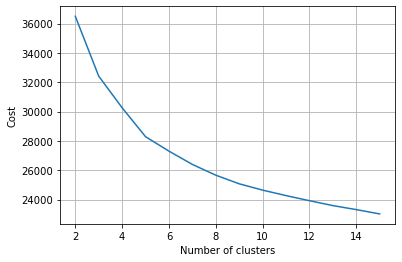

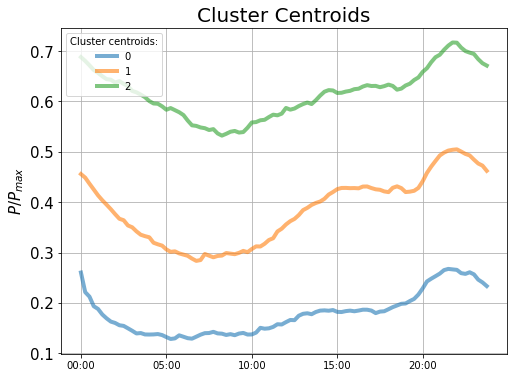

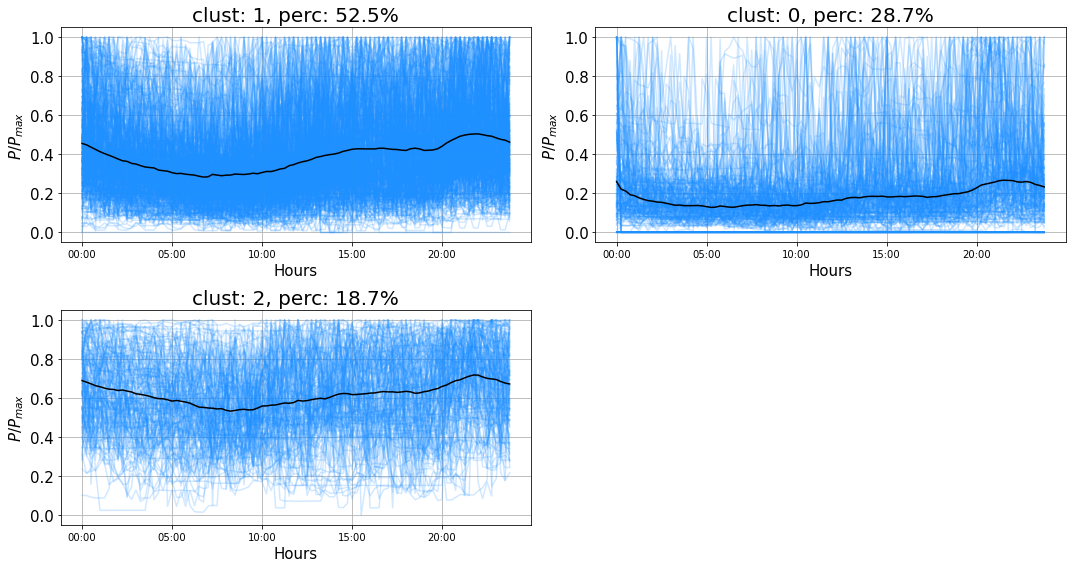

In [5]:
#CURVAS DIARIAS
plot_cost_vs_clusters(X_daily_norm, max_clusters=15)
n_clusters = 3

algorithm = KMeans
model = algorithm(n_clusters).fit(X_daily_norm)
clust = pd.Series(model.labels_, index=X_daily_norm.index)
plot_cluster_centroids(X_daily_norm, clust)
plot_clustered_profiles(X_daily_norm, clust)

# 2. Clustering mean daily profiles

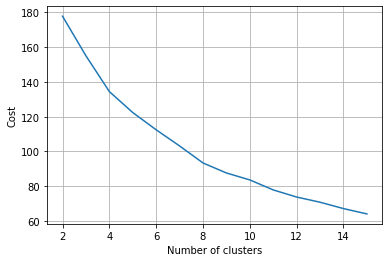

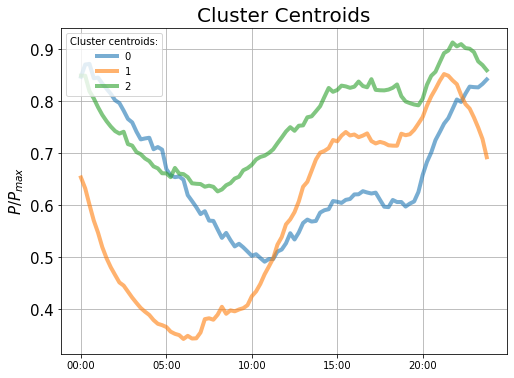

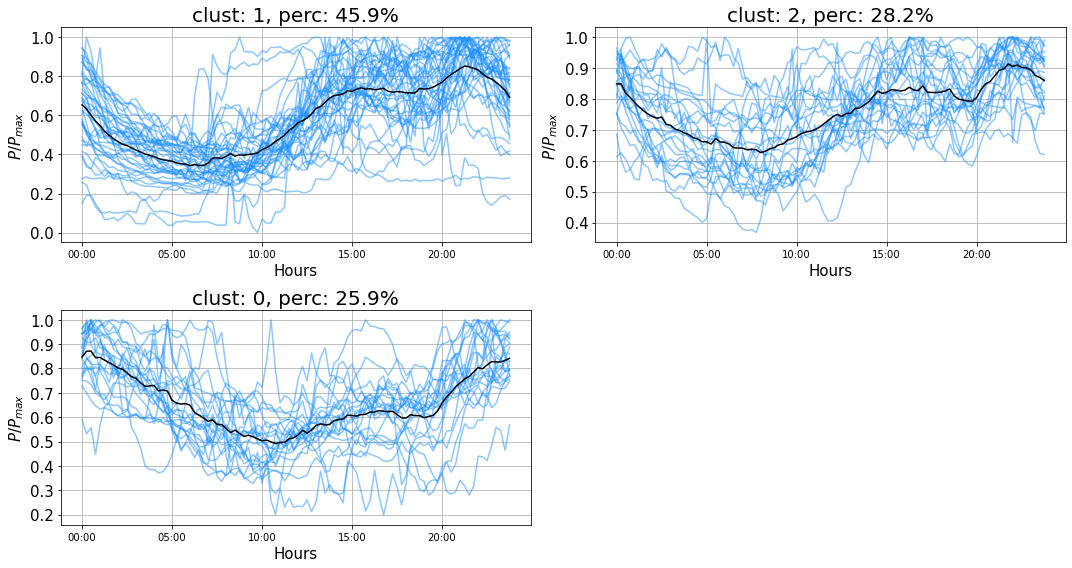

In [6]:
#CURVAS PROMEDIO DIA LABORAL
plot_cost_vs_clusters(X_daily_mean_workingdays_norm, max_clusters=15)
n_clusters = 3

algorithm = KMeans
model = algorithm(n_clusters).fit(X_daily_mean_workingdays_norm)
clust = pd.Series(model.labels_, index=X_daily_mean_workingdays_norm.index)
plot_cluster_centroids(X_daily_mean_workingdays_norm, clust)
plot_clustered_profiles(X_daily_mean_workingdays_norm, clust, alpha=0.5)

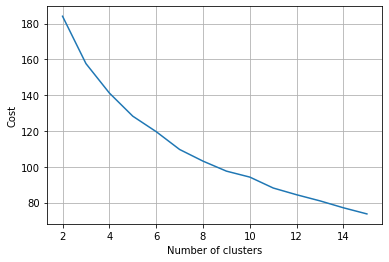

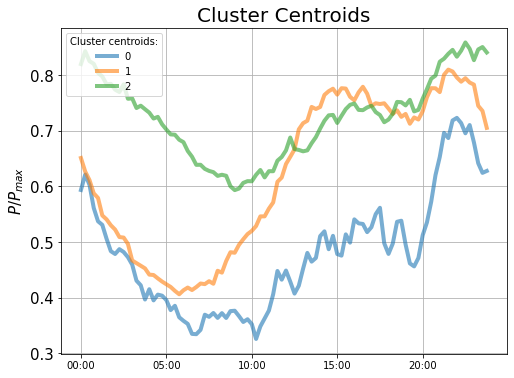

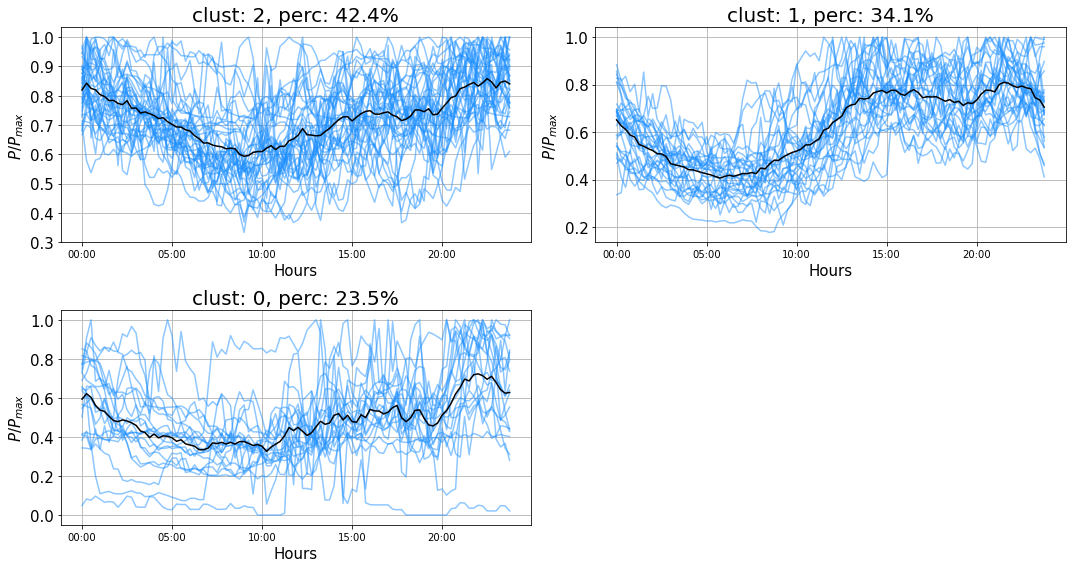

In [7]:
#CURVA PROMEDIO FIN DE SEMANA
plot_cost_vs_clusters(X_daily_mean_weekends_norm, max_clusters=15)
n_clusters = 3

algorithm = KMeans
model = algorithm(n_clusters).fit(X_daily_mean_weekends_norm)
clust = pd.Series(model.labels_, index=X_daily_mean_weekends_norm.index)
plot_cluster_centroids(X_daily_mean_weekends_norm, clust)
plot_clustered_profiles(X_daily_mean_weekends_norm, clust, alpha=0.5)

# 3. Clustering mean weekly profile

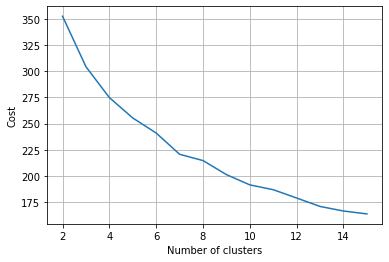

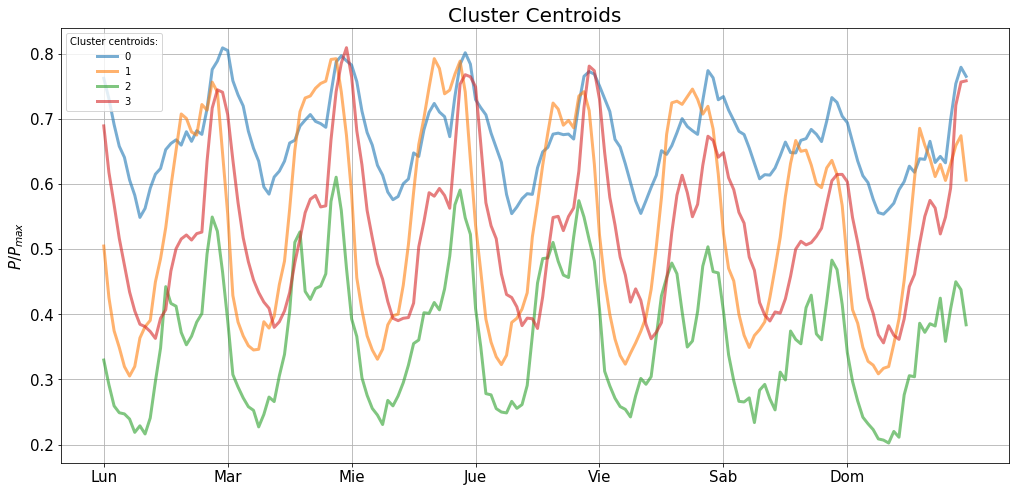

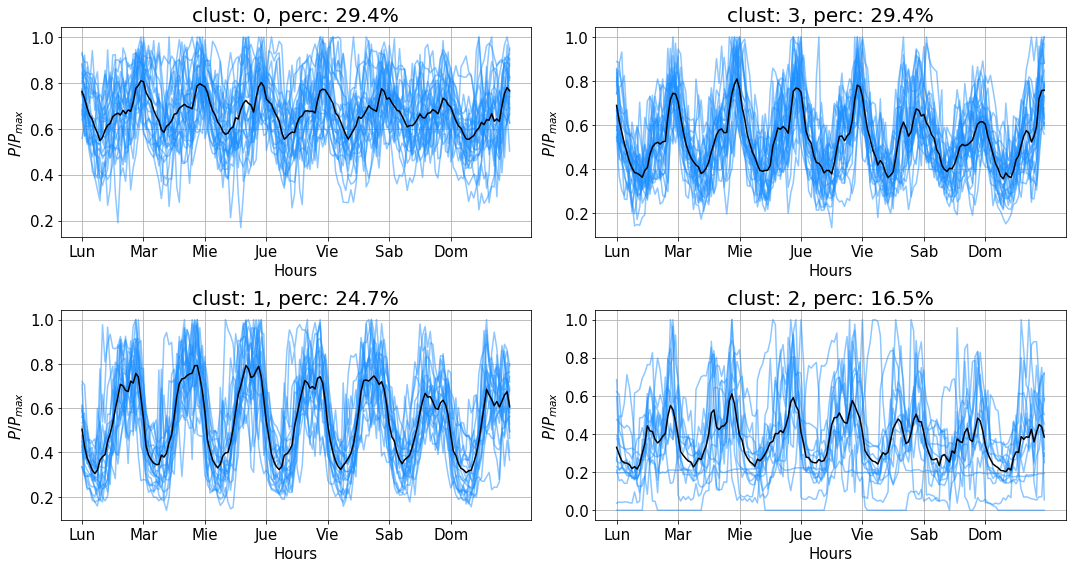

In [8]:
#CURVAS SEMANALES
plot_cost_vs_clusters(X_weekly_mean_norm, max_clusters=15)
n_clusters = 4

algorithm = KMeans
model = algorithm(n_clusters,n_init=12345).fit(X_weekly_mean_norm.values)
clust = pd.Series(model.labels_, index=X_weekly_mean_norm.index)
plot_cluster_centroids(X_weekly_mean_norm, clust, lw=3, alpha=0.6)
plot_clustered_profiles(X_weekly_mean_norm, clust, n_cols=2, alpha=0.5)